### Baltimore City Police Emergency and Non-Emergency 911 Calls for Service, 2015-2018

This notebook will analyze Baltimore's 911 police calls for service data, which can be obtained from [Open Baltimore](https://data.baltimorecity.gov/Public-Safety/911-Police-Calls-for-Service/xviu-ezkt). 

The data contains the following fields:


* recordId: Int variable, record identifier
* callDateTime: Floating timestamp, YYYY-MM-DD HH:MM:SS
* priority: String variable, priority of call
* district: String variable, quadrant of Baltimore	
* description: String variable, description of the emergency call
* callNumber: String variable, call identifier
* incidentLocation: String variable, location of incident 	
* location: String variable, location of call

The calls dates range from 2015-01-01 to present (as of 2018-06-14). There are 3.55 million rows, each row a call. Data is automatically refreshed multiple times a day.

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import re
from string import punctuation
from datetime import datetime, timedelta
import folium
from folium import plugins

%matplotlib inline

In [53]:
calls = pd.read_json('https://data.baltimorecity.gov/resource/m8g9-abgb.json?$limit=5000000')
calls.head()

,calldatetime,callnumber,description,district,incidentlocation,location,location_address,location_city,location_state,priority,recordid
0,2018-02-05T11:29:00.000,P180361209,INVEST,CD,0 CHARLES PZ,NaN,0 CHARLES,PZ BALTIMORE,MD,Low,3213567
1,2017-09-25T06:07:00.000,P172680397,PRKG COMPLAINT,SD,E100,NaN,NaN,NaN,NaN,Non-Emergency,2874965
2,2018-06-04T14:02:00.000,P181551495,ARMED PERSON,WD,N PAYSON ST/PENROSE AV,NaN,N PAYSON ST,BALTIMORE,MD,High,3529597
3,2018-06-04T14:11:00.000,P181551516,DISORDERLY,SD,2000 E MCCOMAS ST,"{'type': 'Point', 'coordinates': [-76.58958, 3...",2000 E MCCOMAS ST,BALTIMORE,MD,Medium,3529620
4,2018-06-04T14:08:00.000,P181551501,NARCOTICS ONVIEW,CD,200 N EUTAW ST,"{'type': 'Point', 'coordinates': [-76.621111, ...",200 N EUTAW ST,BALTIMORE,MD,Medium,3529624


### Creating New features

In [54]:
"""Extracts call date, hour, and day from callDateTime"""
calls['timeStamp'] = pd.to_datetime(calls['calldatetime'])
calls['callDate'] = calls['timeStamp'].dt.date
calls['Hour'] = calls['timeStamp'].apply(lambda x: x.hour)
calls['Day'] = calls['timeStamp'].dt.strftime('%A')
calls.head()

,calldatetime,callnumber,description,district,incidentlocation,location,location_address,location_city,location_state,priority,recordid,timeStamp,callDate,Hour,Day
0,2018-02-05T11:29:00.000,P180361209,INVEST,CD,0 CHARLES PZ,NaN,0 CHARLES,PZ BALTIMORE,MD,Low,3213567,2018-02-05 11:29:00,2018-02-05,11,Monday
1,2017-09-25T06:07:00.000,P172680397,PRKG COMPLAINT,SD,E100,NaN,NaN,NaN,NaN,Non-Emergency,2874965,2017-09-25 06:07:00,2017-09-25,6,Monday
2,2018-06-04T14:02:00.000,P181551495,ARMED PERSON,WD,N PAYSON ST/PENROSE AV,NaN,N PAYSON ST,BALTIMORE,MD,High,3529597,2018-06-04 14:02:00,2018-06-04,14,Monday
3,2018-06-04T14:11:00.000,P181551516,DISORDERLY,SD,2000 E MCCOMAS ST,"{'type': 'Point', 'coordinates': [-76.58958, 3...",2000 E MCCOMAS ST,BALTIMORE,MD,Medium,3529620,2018-06-04 14:11:00,2018-06-04,14,Monday
4,2018-06-04T14:08:00.000,P181551501,NARCOTICS ONVIEW,CD,200 N EUTAW ST,"{'type': 'Point', 'coordinates': [-76.621111, ...",200 N EUTAW ST,BALTIMORE,MD,Medium,3529624,2018-06-04 14:08:00,2018-06-04,14,Monday


In [56]:
def long_lat(loc):
    """Extracts longitude and latitude from the locations column"""
    lat = None
    long = None
    
    if loc:
        try:
            loc = loc['coordinates']
            lat = loc[1]
            long = loc[0] 
        except:
            pass 
    else:
        return 
    return pd.Series([lat, long], index=['lat', 'long'])

calls[['lat', 'long']] = calls['location'][:].apply(long_lat)

calls.head()

,calldatetime,callnumber,description,district,incidentlocation,location,location_address,location_city,location_state,priority,recordid,timeStamp,callDate,Hour,Day,lat,long
0,2018-02-05T11:29:00.000,P180361209,INVEST,CD,0 CHARLES PZ,NaN,0 CHARLES,PZ BALTIMORE,MD,Low,3213567,2018-02-05 11:29:00,2018-02-05,11,Monday,NaN,NaN
1,2017-09-25T06:07:00.000,P172680397,PRKG COMPLAINT,SD,E100,NaN,NaN,NaN,NaN,Non-Emergency,2874965,2017-09-25 06:07:00,2017-09-25,6,Monday,NaN,NaN
2,2018-06-04T14:02:00.000,P181551495,ARMED PERSON,WD,N PAYSON ST/PENROSE AV,NaN,N PAYSON ST,BALTIMORE,MD,High,3529597,2018-06-04 14:02:00,2018-06-04,14,Monday,NaN,NaN
3,2018-06-04T14:11:00.000,P181551516,DISORDERLY,SD,2000 E MCCOMAS ST,"{'type': 'Point', 'coordinates': [-76.58958, 3...",2000 E MCCOMAS ST,BALTIMORE,MD,Medium,3529620,2018-06-04 14:11:00,2018-06-04,14,Monday,39.264612,-76.589580
4,2018-06-04T14:08:00.000,P181551501,NARCOTICS ONVIEW,CD,200 N EUTAW ST,"{'type': 'Point', 'coordinates': [-76.621111, ...",200 N EUTAW ST,BALTIMORE,MD,Medium,3529624,2018-06-04 14:08:00,2018-06-04,14,Monday,39.292098,-76.621111


In [58]:
calls.to_pickle('baltimore_911_calls')

In [3]:
calls = pd.read_pickle('baltimore_911_calls')

### Data Visualization

In [36]:
# Group call counts by each day starting from 2015-01-01
call_count = calls.groupby('callDate').count()['recordid']

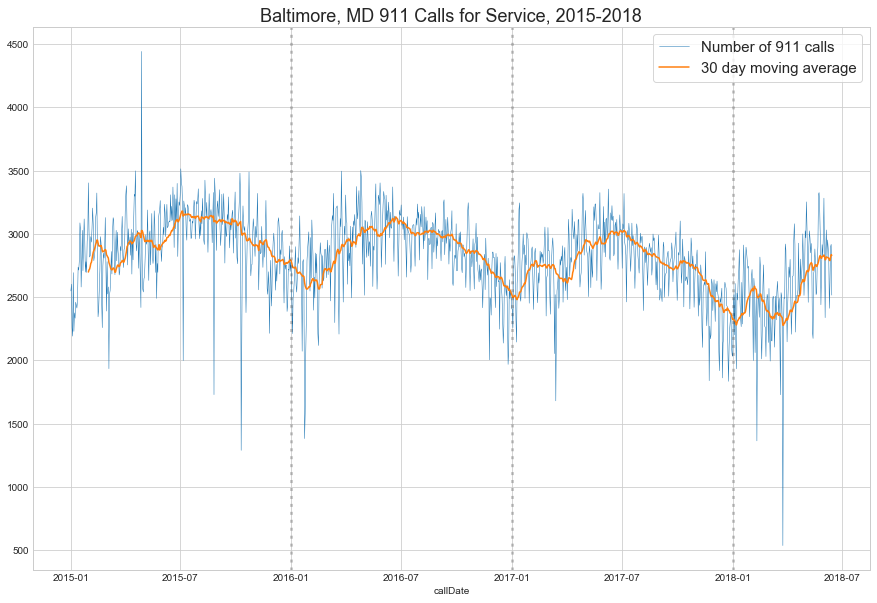

In [151]:
# graph countplot of number of calls each day
c = call_count.plot(figsize=(15,10), label = 'Number of 911 calls', linewidth=0.5)

# graph rolling average for every thirty days
c = call_count.rolling(window=30).mean().plot(figsize=(15,10), label = '30 day moving average')

def yearly_mark(date):
    """Separates each year in graph with vertical line"""
    plt.axvline(date, color='black', linewidth=3, linestyle=':', alpha=0.2)
    
yearly_mark('2016-01-01')
yearly_mark('2017-01-01')
yearly_mark('2018-01-01')

plt.legend(prop={'size': 15}, loc=1, frameon=True)
plt.title('Baltimore, MD 911 Calls for Service, 2015-2018', fontsize=18)
plt.show()

There is a spike in 911 calls around April/May of 2015. If we zoom into this part of the graph by limiting the x-axis to just 2015 calls, we see that this happens on April 27th, 2015. This was the date of Freddie Gray's funeral, which was followed by a sharp increase in civil disorder in Baltimore.

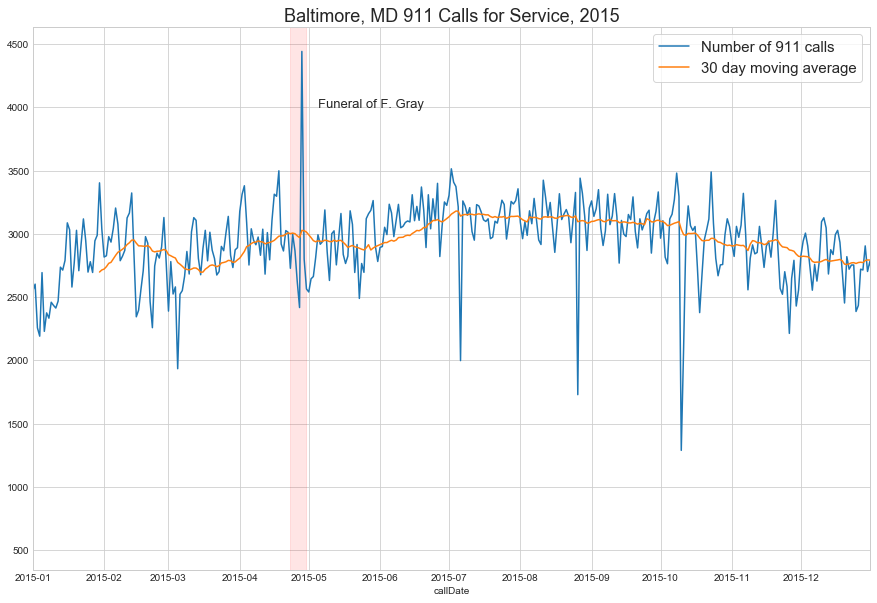

In [152]:
# to isolate year 2015, set range starting from 2015-01-01 to 2015-12-31
startdate = datetime.strptime('2015-01-01', "%Y-%m-%d").date()
enddate = datetime.strptime('2015-12-31', "%Y-%m-%d").date()

# graph number of calls per day
calls.groupby('callDate').count()['recordid'].plot(figsize=(15,10),label = 'Number of 911 calls')
calls.groupby('callDate').count()['recordid'].rolling(window=30).mean().plot(figsize=(15,10), label = '30 day moving average')

# limit x axis to 2015 only
plt.xlim([startdate,enddate])

# label and mark spike in 911 call
plt.axvspan('2015-04-23', '2015-04-30', alpha=0.1, color='r')
plt.text('2015-05-05', 4000, 'Funeral of F. Gray', fontsize=13)

plt.legend(prop={'size': 15}, frameon=True)
plt.title('Baltimore, MD 911 Calls for Service, 2015', fontsize=18)
plt.show()

Here are the top 5 most common reasons for 911 call service. We will disregard the top reason '911/NO VOICE', since we are only interested in categorized reasons for the call. We will also exclude routine non-emergency traffic stops.

In [8]:
calls['description'].value_counts(ascending=False).head(10)

911/NO  VOICE       538337
DISORDERLY          309364
Traffic Stop        222750
COMMON ASSAULT      153165
AUTO ACCIDENT       143734
NARCOTICSOutside    126482
SILENT ALARM        105813
FAMILY DISTURB       87541
Repairs/Service      79591
OTHER                77152
Name: description, dtype: int64

Text(0.5,1,'Top 3 Most Common 911 Call Descriptions')

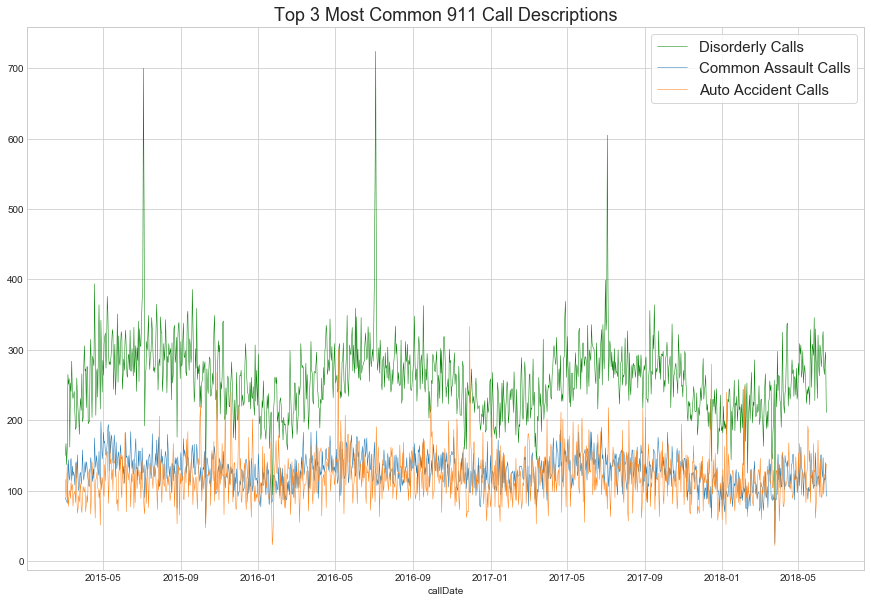

In [154]:
# graph disorderly calls
call_disorderly = calls[calls['description'] == 'DISORDERLY'].groupby('callDate').count()['recordid']
call_disorderly.plot(figsize=(15,10), label = 'Disorderly Calls', linewidth=0.5, color='g')

# graph common assault calls
call_assault = calls[calls['description'] == 'COMMON ASSAULT'].groupby('callDate').count()['recordid']
call_assault.plot(figsize=(15,10), label = 'Common Assault Calls', linewidth=0.5)

# graph auto accident calls
call_autoAccident = calls[calls['description'] == 'AUTO ACCIDENT'].groupby('callDate').count()['recordid']
call_autoAccident.plot(figsize=(15,10), label = 'Auto Accident Calls', linewidth=0.5)

plt.legend(prop={'size': 15}, frameon=True)
plt.title('Top 3 Most Common 911 Call Descriptions', fontsize=18)

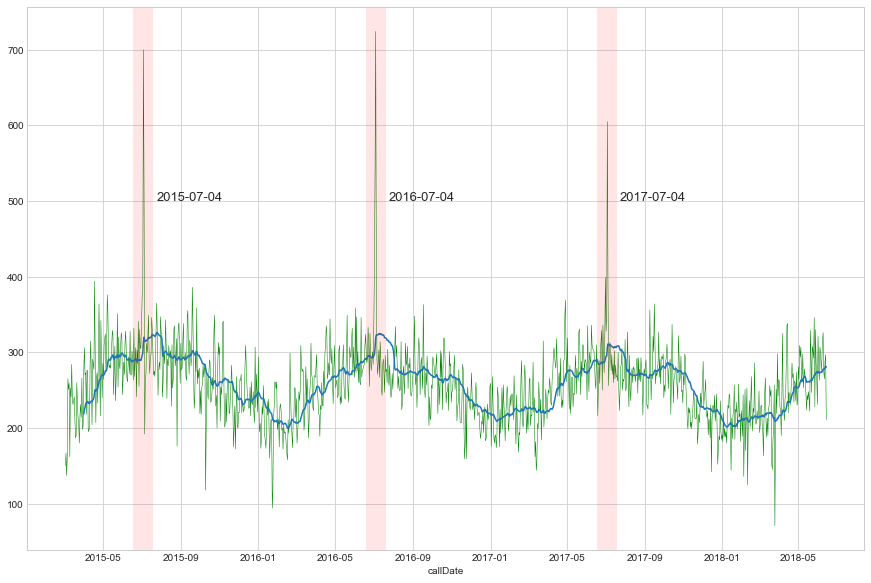

In [155]:
call_disorderly.plot(figsize=(15,10), label = 'Disorderly Calls', linewidth=0.5, color='g')
call_disorderly.rolling(window=30).mean().plot(figsize=(15,10))

def july_4th(date):
    """Marks and labels dates with spike in disorderly calls"""
    plt.axvline(date, color='r', linewidth=20, alpha=0.1)
    date_1 = datetime.strptime(date, "%Y-%m-%d")
    plt.text(date_1 + timedelta(days=20), 500, date, fontsize=13)
    
july_4th('2015-07-04')
july_4th('2016-07-04')
july_4th('2017-07-04')

## Heatmaps

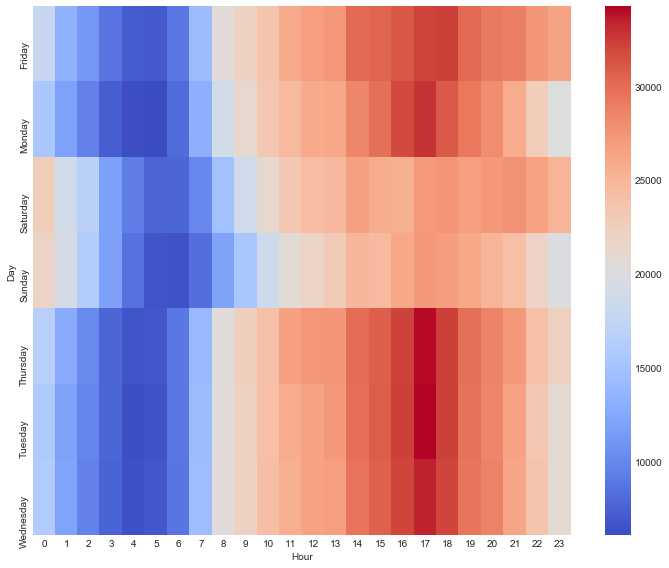

In [39]:
calls_dayHour = calls.groupby(by=['Day', 'Hour']).count()['recordid'].unstack()
calls_dayHour

plt.figure(figsize=(10,8))
sns.heatmap(calls_dayHour, cmap='coolwarm')
plt.tight_layout()

#### Use the following [nbviewer](https://nbviewer.jupyter.org/github/ymericson/example-notebook/blob/master/Baltimore%20911%20Calls.ipynb) link to view the below JavaScript content 

In [74]:
# map Baltimore using central latitude and longitude
baltLatLong = [39.299236, -76.609383]
baltMap = folium.Map(baltLatLong, zoom_start=12)

# convert lat and long from calls in a list-in-list format for heatmap
calls_latLong_list = calls[['lat', 'long']].dropna()[:50000].values.tolist()

# plot heatmap
baltMap.add_child(plugins.HeatMap(calls_latLong_list, radius=10))
baltMap